In [2]:
!pip install scikit-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl (41.2 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load your data
df = pd.read_csv('df.csv')  # Change the path if needed

# Separate features and target
X = df.filter(like='feat_')  # Select only feature columns
y = df['Class']

# 1. Feature Scale Checking
feature_means = X.mean()
feature_stds = X.std()

print("\nFeature mean range:", feature_means.min(), "to", feature_means.max())
print("Feature std range:", feature_stds.min(), "to", feature_stds.max())





Feature mean range: -16.16497387090451 to 3.0988467573647016
Feature std range: 0.15661198221053535 to 1.6235398124554024


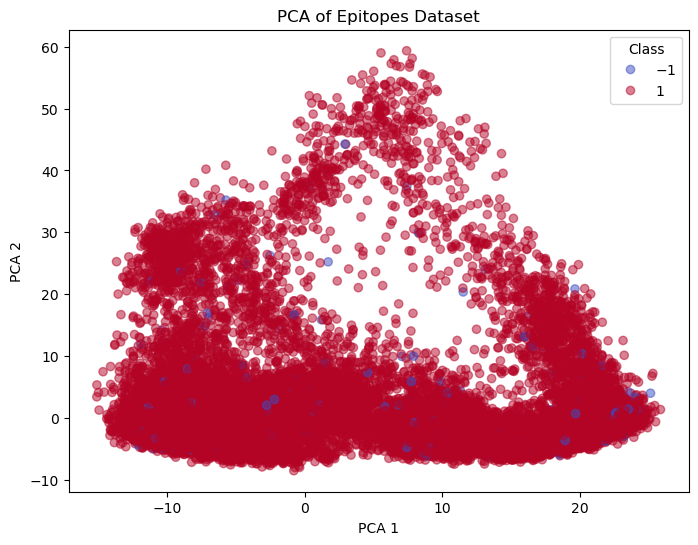

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load your data
df = pd.read_csv('df.csv')  # <-- replace with your path

# Separate features and target
X = df.filter(like='feat_')  # Only feature columns
y = df['Class']

# 1. Handle missing values
X = X.fillna(X.mean())  # Fill NaNs with feature means

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Epitopes Dataset')
plt.legend(*scatter.legend_elements(), title="Class")
plt.show()


In [9]:
!pip install scikit-learn imbalanced-learn matplotlib


  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


PCA reduced dimensions to: 858 components
After SMOTE, Class distribution:
Class
 1    44262
-1    44262
Name: count, dtype: int64


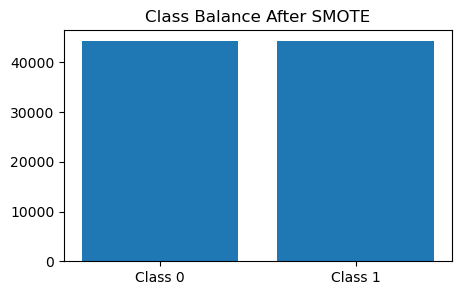

In [12]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('df.csv')  # Replace with your path

# Separate features and target
X = df.filter(like='feat_')  # Features only
y = df['Class']

# --- Pre-processing ---

# 1. Handle missing data: fill NaNs with column means
X = X.fillna(X.mean())

# 2. Remove basic outliers (optional: here we clip extreme values)
# Clipping at 1st and 99th percentile
lower = X.quantile(0.01)
upper = X.quantile(0.99)
X = X.clip(lower=lower, upper=upper, axis=1)

# 3. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Feature Reduction ---

# 4. Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced dimensions to: {X_pca.shape[1]} components")

# --- Class Rebalancing ---

# 5. Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_pca, y)

print(f"After SMOTE, Class distribution:\n{pd.Series(y_balanced).value_counts()}")

# --- Final output ---
# Now you can use (X_balanced, y_balanced) for training any model!

# Optional: visualize new class distribution
plt.figure(figsize=(5,3))
plt.bar(['Class 0', 'Class 1'], pd.Series(y_balanced).value_counts())
plt.title('Class Balance After SMOTE')
plt.show()


In [1]:
import pandas as pd

df = pd.read_csv('df.csv')
print(df.shape)
print(df.columns[:5])


(45000, 1290)
Index(['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos',
       'Info_AA'],
      dtype='object')


In [ ]:
!pip install xgboost


In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('df.csv')

# Separate features, labels, and group
X = df.filter(like='feat_')
y = df['Class']
groups = df['Info_cluster']

# --- Pre-processing ---

# Fill missing values
X = X.fillna(X.mean())

# Clip outliers
lower = X.quantile(0.01)
upper = X.quantile(0.99)
X = X.clip(lower=lower, upper=upper, axis=1)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature reduction: PCA
pca = PCA(n_components=100)  # Reduce faster: just 100 components instead of 95% variance
X_pca = pca.fit_transform(X_scaled)

# --- Modelling ---

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Grouped Cross-validation
gkf = GroupKFold(n_splits=5)

# Balanced Accuracy scorer
scorer = make_scorer(balanced_accuracy_score)

# Store results
results = {}

# Evaluate each model
for name, model in models.items():
    scores = cross_val_score(model, X_pca, y, groups=groups, cv=gkf, scoring=scorer)
    results[name] = scores
    print(f"{name} Balanced Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Find the best model
best_model_name = max(results, key=lambda k: np.mean(results[k]))
print(f"\n Best model based on Balanced Accuracy: {best_model_name}")


RandomForest Balanced Accuracy: 0.5000 ± 0.0000
LogisticRegression Balanced Accuracy: 0.5000 ± 0.0000


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\swath\anaconda3\envs\finalenv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\swath\anaconda3\envs\finalenv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\Users\swath\anaconda3\envs\finalenv\lib\site-packages\xgboost\sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [-1  1]


In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('df.csv')  # Replace with your correct path

# Separate features, target, and group
X = df.filter(like='feat_')
y = df['Class']
groups = df['Info_cluster']

# --- Pre-processing ---

# Fill missing values
X = X.fillna(X.mean())

# Clip extreme outliers
lower = X.quantile(0.01)
upper = X.quantile(0.99)
X = X.clip(lower=lower, upper=upper, axis=1)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for feature reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# --- Model ---

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up GroupKFold cross-validation
gkf = GroupKFold(n_splits=5)

# Use balanced accuracy as the scoring metric
scorer = make_scorer(balanced_accuracy_score)

# Cross-validation
rf_scores = cross_val_score(rf_model, X_pca, y, groups=groups, cv=gkf, scoring=scorer)

# Print the results
print(f"Random Forest Balanced Accuracy: {np.mean(rf_scores):.4f} ± {np.std(rf_scores):.4f}")


In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv('df.csv')

# --- Sample 3000 rows only ---
df = df.sample(3000, random_state=42)

# Separate features and labels
X = df.filter(like='feat_')
y = df['Class']
groups = df['Info_cluster']

# Preprocessing
X = X.fillna(X.mean())
X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=50)  # 50 components only
X_pca = pca.fit_transform(X_scaled)

# Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

gkf = GroupKFold(n_splits=5)
scorer = make_scorer(balanced_accuracy_score)

# Cross-validation
scores = cross_val_score(rf_model, X_pca, y, groups=groups, cv=gkf, scoring=scorer)

# Print results
print("\nRandom Forest Balanced Accuracy: {:.4f} ± {:.4f}".format(np.mean(scores), np.std(scores)))



Random Forest Balanced Accuracy: 0.5000 ± 0.0000


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# --- Load Training Data ---

df = pd.read_csv('df.csv')  # << direct load

# Separate features and target
X = df.filter(like='feat_')
y = df['Class']

# Preprocessing: fill missing values, clip outliers, scale
X = X.fillna(X.mean())
lower = X.quantile(0.01)
upper = X.quantile(0.99)
X = X.clip(lower=lower, upper=upper, axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to reduce dimensionality
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# --- Load Holdout Data ---

df_holdout = pd.read_csv('df_holdout.csv')  # << direct load

X_holdout = df_holdout.filter(like='feat_')
y_holdout = df_holdout['Class']

# Apply same preprocessing to holdout
X_holdout = X_holdout.fillna(X_holdout.mean())
X_holdout = X_holdout.clip(lower=lower, upper=upper, axis=1)
X_holdout_scaled = scaler.transform(X_holdout)
X_holdout_pca = pca.transform(X_holdout_scaled)

# --- Train Model on Full Training Set ---

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_pca, y)

# --- Evaluate on Holdout Set ---

y_pred_proba = xgb_model.predict_proba(X_holdout_pca)[:, 1]
holdout_auc = roc_auc_score(y_holdout, y_pred_proba)

print(f"Holdout AUC: {holdout_auc:.4f}")